4. Credit Card Fraud Detection


# Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

# Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

------------------------- Project Progress 2 ---------------------------

# (1) Data Processing

In [ ]:
# our data is uploaded upon googledrive
from google.colab import drive
drive.mount('/content/gdrive')
data_path = ('/content/gdrive/My Drive/Colab Notebooks/APS360_Project/creditcard.csv')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import TensorDataset,DataLoader

import os

train_path = '/content/gdrive/My Drive/Colab Notebooks/APS360_Project/train.csv'
valid_path = '/content/gdrive/My Drive/Colab Notebooks/APS360_Project/validation.csv'
test_path = '/content/gdrive/My Drive/Colab Notebooks/APS360_Project/test.csv'

In [ ]:
def split_train_test(data_path):
    """
    切分训练集，测试集,分别保存文件
    Args:
        - data_path: 原始数据路径
    Returns:
        - train_data: 训练数据
        - test_data: 测试数据
    """
    
    if (os.path.isfile(train_path) == True and os.path.isfile(test_path) == True
        and os.path.isfile(valid_path) == True):
      train_data = pd.read_csv(train_path)
      valid_data = pd.read_csv(valid_path)
      test_data = pd.read_csv(test_path)
      return train_data, valid_data, test_data

    data = pd.read_csv(data_path)
    train_data, test_data = train_test_split(data,test_size=0.2,random_state=0)
    train_data, valid_data = train_test_split(train_data, test_size=0.25, random_state=0) 
    # train 0.6, valid 0.2, test 0.2
    assert train_data.shape[0]+valid_data.shape[0]+test_data.shape[0] == data.shape[0]
    train_data.to_csv(train_path,index=False)
    valid_data.to_csv(valid_path,index=False)
    test_data.to_csv(test_path,index=False)
    return train_data, valid_data, test_data



def pre_data(data_path=train_path,standard=None,is_Train=True):
    """
    数据预处理
    Args:
        - data_path: 数据文件存储路径
        - standard: 数据标准化器
        - is_Train: default is True ,是否为训练
    Return:
        - X: 数据特征
        - Y: 数据标记
        - standard: 数据标准化
    """
    data = pd.read_csv(data_path)
    col = set(data.columns)

    time_amount_data = data[['Time','Amount']]
    time_amount_data = np.array(time_amount_data)
    
    label = data[['Class']]
    label = np.array(label).reshape(-1,) #only one row
    
    
    col = col -set(["Class","Time","Amount"])
    
    other_data = np.array(data[col])
    
    
    # 预处理
    # 对time和amount数据进行归一化
    
    if standard == None:
        standard = StandardScaler()
        time_amount_data = standard.fit_transform(time_amount_data)
    else:
        time_amount_data = standard.transform(time_amount_data)

    
    X = np.concatenate([other_data,time_amount_data],axis=1)
    Y = label
    # SMOTE
    if is_Train:
        # smote = SMOTE(random_state=0)
        pipeline = SMOTE(random_state=0, sampling_strategy=0.005)
        # over = SMOTE(random_state=0, sampling_strategy=0.005)
        # under = RandomUnderSampler(random_state=0, sampling_strategy=0.1)
        # steps = [('o', over), ('u', under)]
        # pipeline = Pipeline(steps=steps)
        X, Y = pipeline.fit_resample(X, label)
    # assert X.shape[0] == Y.shape[0]
    return X,Y,standard


def check_feature(data_path=train_path):
    
    #查看不同类别的特征分布
    
    df = pd.read_csv(data_path)
    anomalous_features = df.iloc[:,1:29].columns

    plt.figure(figsize=(12,28*4))
    gs = gridspec.GridSpec(28, 1)
    
    for i, cn in enumerate(df[anomalous_features]):
            
        ax = plt.subplot(gs[i])
        sns.distplot(df[cn][df.Class == 1], bins=50,color='blue') 
        sns.distplot(df[cn][df.Class == 0], bins=50,color='orange') 
        ax.set_xlabel('')
        ax.set_title('histogram of feature: ' + str(cn))
    plt.savefig("feature.jpeg")
            

In [ ]:
train_data, valid_data, test_data = split_train_test(data_path)

In [ ]:
len(train_data[train_data.Class == 0]), len(train_data[train_data.Class == 1])
X, Y, Standardscaler =  pre_data()
Y.size, np.count_nonzero(Y)

(171453, 853)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

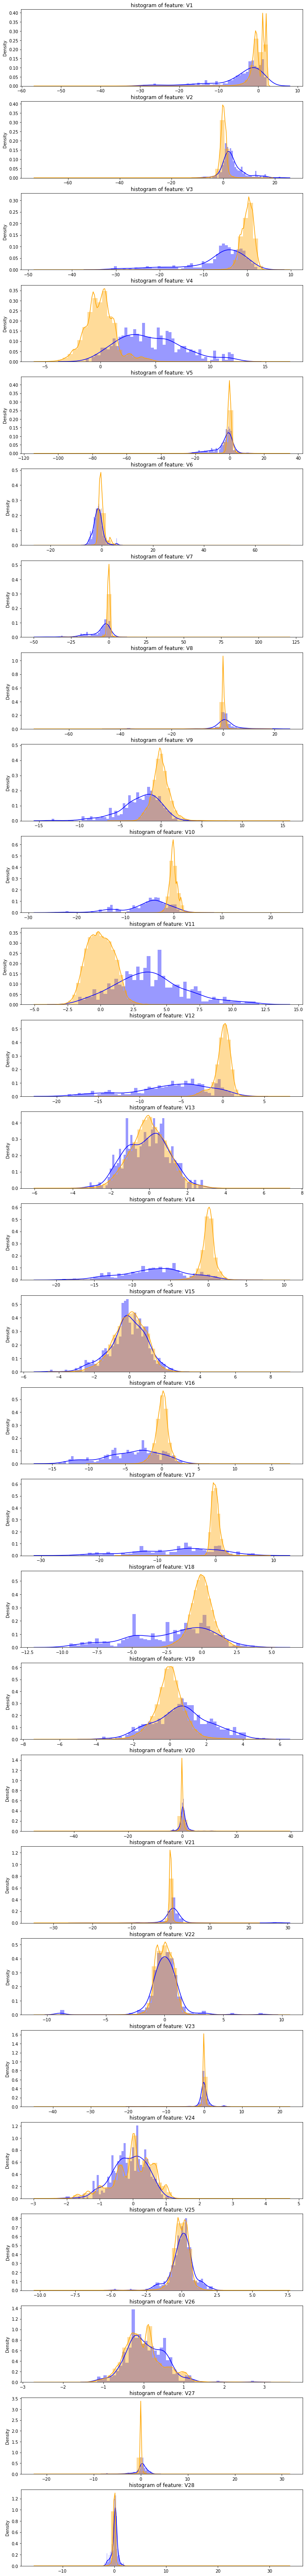

In [ ]:
check_feature(data_path)

#  Helper Function 


In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn import metrics

def score_baseline(model, test_x, test_y):
    pred_y = model.predict(test_x)
    print("prediction:",pred_y[-10:])
    print("real label:",test_y[-10:])
    acc = accuracy_score(test_y,pred_y)
    f1 = f1_score(test_y, pred_y, average='binary')
    fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    print("Accuracy: {:.3f}\tF1 socre: {:.3f}\tAUC:{:.3f}".format(acc, f1, auc))

def score_LSTM(model, data_loader):

    correct, total = 0, 0
    for data, labels in iter(data_loader):
            out = model(data[None, :])
            pred = out.max(1, keepdim=True)[1]
            # print(pred)
            # print(out)
            target = labels[-1][None,:].max(1)[1]
            # print(target[None,:])
            if target[None,:] == pred:
              correct += 1
            total += labels[-1].shape[0]
    # for data, labels in data_loader:
    #     output = model(data)
    #     print(output)
    #     return 
        # 
        # correct += pred.eq(labels.view_as(pred)).sum().item()
        # total += labels.shape[0]

    return correct / total

    # pred_y = model(test_x)
    # acc = accuracy_score(test_y,pred_y)
    # f1 = f1_score(test_y, pred_y, average='binary')
    # fpr, tpr, thresholds = metrics.roc_curve(test_y, pred_y, pos_label=1)
    # auc = metrics.auc(fpr, tpr)
    # print("Accuracy: {:.3f}\tF1 socre: {:.3f}\tAUC:{:.3f}".format(acc, f1, auc))

def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

In [ ]:
from torch.utils.data import Dataset
class MyDataset(Dataset):
 
  def __init__(self, data):
 
    x=data.iloc[:,0:30].values
    y=pd.get_dummies(train_data.iloc[:,30].values).values
    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)

  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

class MyDataset_2(Dataset):
  def __init__(self, data_x, data_y):
 
    x=data_x
    # y=data.iloc[:,30].values
    # y=pd.get_dummies(data_y.values).values
    y = np.zeros((data_y.size, data_y.max() + 1))
    y[np.arange(data_y.size), data_y] = 1
    # print(y)
    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)

  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

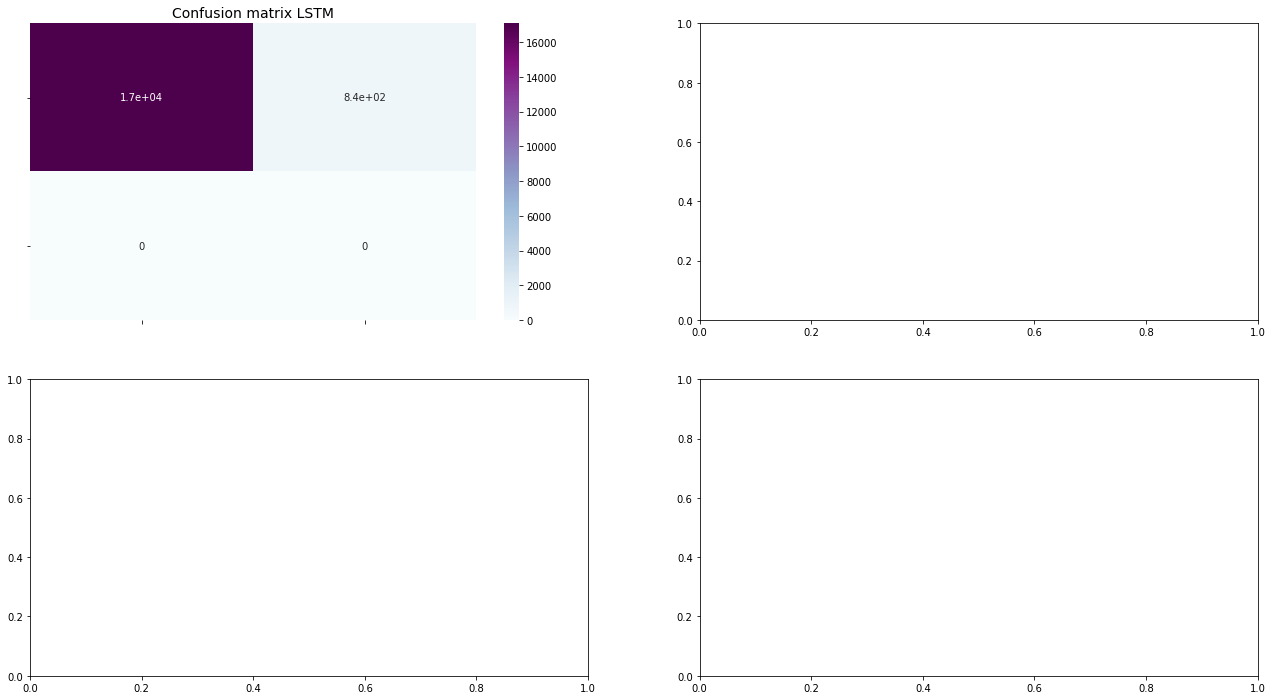

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
def plot_confusion_matrix(cmmodel, test_x, test_y, title='Confusion matrix'):
  pred_y = model.predict(test_x)
  reg_cf = confusion_matrix(test_y, pred_y)
  fig, ax = plt.subplots(2, 2,figsize=(22,12))

  sns.heatmap(reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
  ax[0, 0].set_title(title, fontsize=14)
  ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
  ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

  plt.show()

def plot_confusion_matrix_lstm(TP, FP, FN, TN):
  fig, ax = plt.subplots(2, 2,figsize=(22,12))
  confusion_matrix = np.array([(TP, FP),(FN, TN)],dtype=np.float64)
  ax[0, 0].set_title('Confusion matrix LSTM', fontsize=14)
  sn.heatmap(confusion_matrix, ax=ax[0][0],annot=True, cmap="BuPu")
  ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)
  
  ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)

plot_confusion_matrix_lstm(17084, 835, 0, 0)

# (2). LSTM MODEL

In [ ]:
import torch
import torch.nn as nn

class LstmModel(nn.Module):
    def __init__(self,input_dim=30,hidden_dim=128,out_dim=2,num_lstm_layers=2):
        super(LstmModel,self).__init__()
        self.name = "lstmModel"
        self.hidden_dim = hidden_dim
        self.num_lstm_layers = num_lstm_layers
        self.lstm = nn.LSTM(input_size=input_dim,hidden_size=hidden_dim,num_layers=num_lstm_layers,batch_first=True)
        self.fc = nn.Linear(hidden_dim,out_dim)
        

    def forward(self,x):
        h0 = torch.zeros(self.num_lstm_layers, x.size(0),self.hidden_dim)
        c0 = torch.zeros(self.num_lstm_layers, x.size(0),self.hidden_dim)
        x,_ = self.lstm(x, (h0, c0))
        # x,_ = self.lstm(x)
        x = self.fc(x[:,-1,:])
        return x

def train(model, train_loader, valid_loader,batch_size=1, n_epochs=5, lr=1e-2):
    criterion = nn.CrossEntropyLoss()
    # criterion = nn.BCELoss()
    
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    iters, train_losses, valid_losses, train_acc, val_acc = [], [], [], [], []
    iters_epoch, train_loss_epoch, valid_loss_epoch = [], [], []
    ''' # not working, please ignore
    # train_target = torch.tensor(train_data['Class'].values.astype(np.float32))
    # train = torch.tensor(train_data.drop('Class', axis = 1).values.astype(np.float32)) 
    # train_tensor = torch.utils.data.TensorDataset(train, train_target) 
    # train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = 200, shuffle = False)

    # valid_target = torch.tensor(valid_data['Class'].values.astype(np.float32))
    # valid = torch.tensor(valid_data.drop('Class', axis = 1).values.astype(np.float32)) 
    # valid_tensor = torch.utils.data.TensorDataset(valid, valid_target) 
    # valid_loader = torch.utils.data.DataLoader(dataset = valid_tensor, batch_size = 200, shuffle = False)

    # train_loader = torch.tensor(train_data['Class'].values)
    # valid_loader = torch.tensor(valid_data['Class'].values)
    # train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=1, shuffle=True)
    # valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, num_workers=1, shuffle=True)
    '''

    i = 0
    for epoch in range(n_epochs):
        for data, labels in iter(train_loader):
            optimizer.zero_grad()
            pred = model(data[None, :])
            loss = criterion(pred,labels[-1][None, :])
            loss.backward()
            optimizer.step()

            # save the current training info
            i += 1
            iters.append(i)
            train_losses.append(float(loss))
        # save the current training info
        iters_epoch.append(epoch)
        train_loss_epoch.append(float(loss))

        # for i, (data_v, labels_v) in enumerate(valid_loader):
        # # for data_v, labels_v in iter(valid_loader):
        #     pred = model(data_v[None, :])
        #     loss = criterion(pred, labels_v[-1][None, :])

        #     # save the current validation info
        #     valid_losses.append(float(loss))
        # # save the current validation info
        # valid_loss_epoch.append(float(loss))

        # train_acc.append(score_LSTM(model, train_loader))
        # val_acc.append(score_LSTM(model, valid_data)) 

        # Save the current model (checkpoint) to a file
        model_path = get_model_name(model.name, 0, lr, epoch)
        torch.save(model.state_dict(), model_path)
        # print("epoch {}, train accuracy {}, validation accuracy {}".format(
        #           epoch, train_acc[-1], val_acc[-1]))
        print("epoch {}, train loss {}".format(
                  epoch, train_losses[-1]))
            
    # plot
    plt.title("Training Curve")
    plt.plot(iters, train_losses, label="Train")
    # plt.plot(iters, valid_losses, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(iters_epoch, train_loss_epoch, label="Train")
    # plt.plot(iters_epoch, valid_loss_epoch, label="Validation")
    plt.xlabel("epoch")
    plt.ylabel("Loss")
    plt.show()

    # plt.title("Training Curve")
    # plt.plot(iters, train_acc, label="Train")
    # plt.plot(iters, val_acc, label="Validation")
    # plt.xlabel("Iterations")
    # plt.ylabel("Training Accuracy")
    # plt.legend(loc='best')
    # plt.show()

    # print("Final Training Accuracy: {}".format(train_acc[-1]))
    # print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
# demo run LSTM Model to check
'''
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
data = torch.randn(size=(64,1,30)).to(device)
model = LstmModel()

print(model)
output = model(data)
print(output.shape)
'''

'\ndevice = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")\ndata = torch.randn(size=(64,1,30)).to(device)\nmodel = LstmModel()\n\nprint(model)\noutput = model(data)\nprint(output.shape)\n'

In [ ]:
## dataloader testing # not working, please ignore
'''
train_target = torch.tensor(train_data['Class'].values.astype(np.float32))
train_target = train_target[None, :]
train_tensor = torch.tensor(train_data.drop('Class', axis = 1).values.astype(np.float32)) 
train_tensor = train_tensor[None, :]
train_tensor = torch.utils.data.TensorDataset(train_tensor, train_target) 

train_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = 200, shuffle=False)
# print(train_tensor)
# print(len(train_loader))
'''

"\ntrain_target = torch.tensor(train_data['Class'].values.astype(np.float32))\ntrain_target = train_target[None, :]\ntrain_tensor = torch.tensor(train_data.drop('Class', axis = 1).values.astype(np.float32)) \ntrain_tensor = train_tensor[None, :]\ntrain_tensor = torch.utils.data.TensorDataset(train_tensor, train_target) \n\ntrain_loader = torch.utils.data.DataLoader(dataset = train_tensor, batch_size = 200, shuffle=False)\n# print(train_tensor)\n# print(len(train_loader))\n"

In [ ]:
## dataloader testing # working

# train_x,train_y,standard = pre_data()
# myDs=MyDataset_2(train_x,train_y)
# train_loader=torch.utils.data.DataLoader(myDs,batch_size=10,shuffle=False)
myDs=MyDataset(train_data)
train_loader_1=torch.utils.data.DataLoader(myDs,batch_size=1,shuffle=False)
myDs_v=MyDataset(valid_data)
valid_loader_1=torch.utils.data.DataLoader(myDs_v,batch_size=1,shuffle=False)
i = 0
total = 0
print(len(train_loader_1))
print(len(valid_loader_1))
for data, labels in iter(valid_loader_1):
  total += 1
  # print(data)
  # if torch.all(torch.eq(labels[-1], torch.tensor([0,1]))):
  #   i += 1
    # print(labels[-1])
print(i, total)
  # break
print(train_data)
print(valid_data)

170883
170883


IndexError: ignored

In [ ]:
## model testing # working

model1 = LstmModel()
for i, (data, labels) in enumerate(train_loader):
# for data, labels in iter(valid_loader):
  pred = model1(data[None, :])
  print(pred)
  
  print(labels[-1][None, :])    
  # print(pred[-1,-1])
  # print(labels)
  # print(pred[-1])
  
  
  # criterion = nn.CrossEntropyLoss()
  # loss = criterion(pred[-1],labels)
  break


In [ ]:
# score_LSTM(model0, valid_loader)
correct, total = 0, 0
TP, FP, TN, FN = 0, 0, 0, 0
for data, labels in iter(train_loader):
            out = model2(data[None, :])
            for row in out:

              pred = row.max(1, keepdim=True)[1]
            # print(pred)
            print(out)
            for row in labels[None,:]:
              target = row.max(1)[1]
            # print(target[None,:])
            for i, datas in enumerate(target):
                print(i, datas)
            # for item in target:
                class01 = datas.detach().cpu().numpy()
                pred01 = pred[i].detach().cpu().numpy()[0]
                print(class01)
                print(pred01, pred)
                # print(pred[i])
                if class01 == 0:
                    if class01== pred01:
                      correct += 1
                      TP += 1
                    else:
                      FN += 1
                else:
                    if class01 == pred01:
                      correct += 1
                      TN += 1
                    else:
                      FP += 1
                total += 1
print(correct, total, TP, FP, TN, FN)            

IndexError: ignored

In [ ]:
def train_2(model, num_epochs=20,batch_size=64,lr=1e-4,device='cpu'):
    writer = SummaryWriter(log_dir="./logs")

    avg_train_loss_epoch = []
    avg_val_loss_epoch = []
    train_acc_epoch = []
    val_acc_epoch = []

    # Prepare Data
    train_x,train_y,standard = pre_data(data_path='/content/gdrive/My Drive/Colab Notebooks/APS360_Project/train.csv',is_Train=True)
    assert train_x.shape[0] == train_y.shape[0]
   
    test_x, test_y,_ = pre_data(data_path='/content/gdrive/My Drive/Colab Notebooks/APS360_Project/validation.csv',standard=standard,is_Train=True)
    # test_x,test_y,standard = pre_data(data_path='/content/gdrive/My Drive/Colab Notebooks/APS360_Project/validation.csv',is_Train=True)
    assert test_x.shape[0] == test_y.shape[0]
    assert test_x.shape[1] == train_x.shape[1]

    # Create dataset
    train_x = torch.tensor(train_x,dtype=torch.float32).view(train_x.shape[0],1,train_x.shape[1])
    train_y = torch.tensor(train_y,dtype=torch.long)
    train_dataset = TensorDataset(train_x,train_y)

    test_x = torch.tensor(test_x,dtype=torch.float32).view(test_x.shape[0],1,test_x.shape[1])
    test_y = torch.tensor(test_y,dtype=torch.long)
    test_dataset = TensorDataset(test_x,test_y)

    # Create DataLoader
    train_dataloader = DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
    test_dataloader = DataLoader(dataset=test_dataset,batch_size=batch_size)

    # Prepare Train
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(),lr)


    # Train
    total_step = len(train_dataloader)
    for epoch in range(num_epochs):
        model.train()
        train_acc = 0.0
        train_loss = 0.0
        for i,(x,y) in enumerate(train_dataloader):
            x = x.to(device)
            y = y.to(device)

            pred_y = model(x)
            
            
            train_loss = criterion(pred_y,y)

            train_acc += (pred_y.argmax(1)==y).sum().item()

            optimizer.zero_grad()
            train_loss.backward()
            optimizer.step()

            if (i+1)%1000 == 0:
                print("Epoch {}/{}, Step {}/{} Train_Loss:{}".format(epoch+1,num_epochs,i,total_step,train_loss.item()))
                writer.add_scalar(tag="Train_Loss",scalar_value=train_loss.item(),global_step=epoch*total_step+i)
        writer.add_scalar(tag="Train_Accuracy",scalar_value=train_acc/train_x.shape[0],global_step=epoch)
        print("Epoch: {} Train_Acc:{}".format(epoch+1,train_acc/train_x.shape[0]))
        
        train_acc_epoch.append(train_acc/train_x.shape[0])
        avg_train_loss_epoch.append(train_loss/train_x.shape[0])

        # Validation
        model.eval()
        with torch.no_grad():
            val_acc = 0.0
            val_loss = 0.0
            for x,y in test_dataloader:
                x = x.to(device)
                y = y.to(device)

                pred_y = model(x)
                val_loss += criterion(pred_y,y).item()
                

                val_acc += (pred_y.argmax(1)==y).sum().item()

            print("Val Accuracy:{} Val_Loss:{}".format(val_acc/test_x.shape[0],val_loss/test_x.shape[0]))
            val_acc_epoch.append(val_acc/test_x.shape[0])
            avg_val_loss_epoch.append(val_loss/test_x.shape[0])
            writer.add_scalar(tag="Val_Accuracy",scalar_value=val_acc/test_x.shape[0],global_step=epoch)    
    writer.close()
            
        #print('Epoch %04d  Training Loss %.4f Validation Loss %.4f Training Accuracy %.4f Validation Accuracy %.4f' % (epoch + 1, train_loss/train_x.shape[0], val_loss/test_x.shape[0], 100*train_acc/train_x.shape[0], 100*val_acc/test_x.shape[0]))

    # Save Model
    torch.save(model.state_dict(),"LSTMModel.pth")

            
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()


In [ ]:
"""
  #Plot training loss
    plt.title("Train vs Validation Loss")
    plt.plot(avg_train_loss_epoch, label="Train")
    plt.plot(avg_val_loss_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    plt.show()

    plt.title("Train vs Validation Accuracy")
    plt.plot(train_acc_epoch, label="Train")
    plt.plot(val_acc_epoch, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.legend(loc='best')
    plt.show()
"""

'\n  #Plot training loss\n    plt.title("Train vs Validation Loss")\n    plt.plot(avg_train_loss_epoch, label="Train")\n    plt.plot(avg_val_loss_epoch, label="Validation")\n    plt.xlabel("Epoch")\n    plt.ylabel("Loss")\n    plt.legend(loc=\'best\')\n    plt.show()\n\n    plt.title("Train vs Validation Accuracy")\n    plt.plot(train_acc_epoch, label="Train")\n    plt.plot(val_acc_epoch, label="Validation")\n    plt.xlabel("Epoch")\n    plt.ylabel("Accuracy (%)")\n    plt.legend(loc=\'best\')\n    plt.show()\n'

Epoch 1/20, Step 999/2679 Train_Loss:0.5962356925010681
Epoch 1/20, Step 1999/2679 Train_Loss:0.5601820349693298
Epoch: 1 Train_Acc:0.9950248756218906
Val Accuracy:0.9950295775140887 Val_Loss:0.008313017139086313
Epoch 2/20, Step 999/2679 Train_Loss:0.5025926828384399
Epoch 2/20, Step 1999/2679 Train_Loss:0.47358590364456177
Epoch: 2 Train_Acc:0.9950248756218906
Val Accuracy:0.9950295775140887 Val_Loss:0.00701315779297748
Epoch 3/20, Step 999/2679 Train_Loss:0.419878214597702
Epoch 3/20, Step 1999/2679 Train_Loss:0.39554280042648315
Epoch: 3 Train_Acc:0.9950248756218906
Val Accuracy:0.9950295775140887 Val_Loss:0.006014717124787713
Epoch 4/20, Step 999/2679 Train_Loss:0.3733736574649811
Epoch 4/20, Step 1999/2679 Train_Loss:0.341499388217926
Epoch: 4 Train_Acc:0.9950248756218906
Val Accuracy:0.9950295775140887 Val_Loss:0.005235724577530209
Epoch 5/20, Step 999/2679 Train_Loss:0.32910779118537903
Epoch 5/20, Step 1999/2679 Train_Loss:0.2992958724498749
Epoch: 5 Train_Acc:0.99502487562189

RuntimeError: ignored

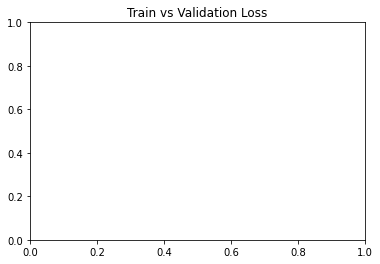

In [ ]:
model2 = LstmModel()

train_x,train_y,standard = pre_data()
myDs=MyDataset_2(train_x,train_y)
train_loader=torch.utils.data.DataLoader(myDs,batch_size=10,shuffle=False)
myDs=MyDataset(valid_data)
valid_loader=torch.utils.data.DataLoader(myDs,batch_size=10,shuffle=False)

#train(model2, train_loader, valid_loader, n_epochs=1)
train_2(model2) #这个能用 不需要前面的dataset了

In [ ]:
# score_LSTM(model0, valid_loader)
def accurcy_LSTM_test(model, test_dataloader, test_x):
  test_acc = 0.0
  total = 0
  TP, FP, TN, FN = 0, 0, 0, 0
  for x,y in test_dataloader:
      x = x.to('cpu')
      y = y.to('cpu')
      
      pred_y = model(x)
      print(pred_y)
      test_acc += (pred_y.argmax(1)==y).sum().item()
      
      # for confusion matrix
      for index in range(len(y)):
        pred = pred_y.argmax(1)[index]
        real = y[index]
        if pred == real:
          if real == 1: TP+=1
          TN += 1
        else:
          if real == 1: FP +=1
          FN += 1
      total += len(y)
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  # F1_score = 2*precision*recall/(recall+precision)

  print("Test Accuracy:", test_acc/test_x.shape[0])
  print("TP: {}, FP: {}, FN: {}, TN: {}".format(TP, FP, FN, TN))
  # print("precision: {}, recall: {}, F1_score: {}".format(precision, recall, F1_score))  
  return (test_acc/test_x.shape[0], TP, FP, FN, TN, precision, recall)##, F1_score)

In [ ]:
def temp (TP, FP, FN, TN):
  precision = TP/(TP+FP)
  recall = TP/(TP+FN)
  F1_score = 2*precision*recall/(recall+precision)
  print(precision, recall, F1_score)

temp(260, 27, 43, 2800)


0.9059233449477352 0.858085808580858 0.8813559322033899


In [ ]:
# test_x, test_y,_ = pre_data(data_path='/content/gdrive/My Drive/Colab Notebooks/APS360_Project/validation.csv',standard=standard,is_Train=True)
test_x,test_y,standard = pre_data(data_path='/content/gdrive/My Drive/Colab Notebooks/APS360_Project/test.csv',is_Train=True)
# Create dataset

test_x = torch.tensor(test_x,dtype=torch.float32).view(test_x.shape[0],1,test_x.shape[1])
test_y = torch.tensor(test_y,dtype=torch.long)
test_dataset = TensorDataset(test_x,test_y)

# Create DataLoader
test_dataloader = DataLoader(dataset=test_dataset,batch_size=64)
model = LstmModel()
model_path = "LSTMModel.pth"
state = torch.load(model_path)
model.load_state_dict(state)
(test_acc, TP, FP, FN, TN, precision, recall, F1_score) = accurcy_LSTM_test(model, test_dataloader, test_x)
plot_confusion_matrix_lstm(TP, FP, FN, TN)

Streaming output truncated to the last 5000 lines.
        [ 1.1676, -1.1613],
        [ 1.1629, -1.1656],
        [ 1.1581, -1.1614],
        [ 1.1715, -1.1742],
        [ 1.1677, -1.1601],
        [ 1.1699, -1.1631],
        [ 1.1691, -1.1663],
        [ 1.1639, -1.1663],
        [ 1.1730, -1.1630],
        [ 1.1641, -1.1563],
        [ 1.1739, -1.1670],
        [ 1.1675, -1.1608],
        [ 1.1622, -1.1666]], grad_fn=<AddmmBackward0>)
tensor([[ 1.1659, -1.1643],
        [ 1.1630, -1.1561],
        [ 1.1706, -1.1655],
        [ 1.1571, -1.1659],
        [ 1.1644, -1.1657],
        [ 1.1651, -1.1664],
        [ 1.1674, -1.1624],
        [ 1.1684, -1.1631],
        [ 1.1690, -1.1668],
        [ 1.1624, -1.1666],
        [ 1.1603, -1.1629],
        [ 1.1701, -1.1627],
        [ 1.1449, -1.1489],
        [ 1.1656, -1.1701],
        [ 1.1636, -1.1663],
        [ 1.1746, -1.1637],
        [ 1.1679, -1.1628],
        [ 1.1674, -1.1556],
        [ 1.1630, -1.1649],
        [ 1.1658, -1.1592]

ValueError: ignored

epoch 0, train loss 1.7504109144210815


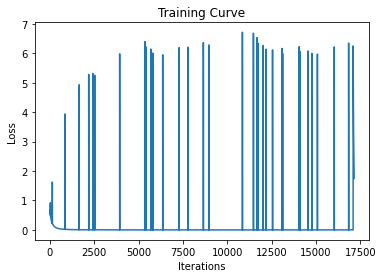

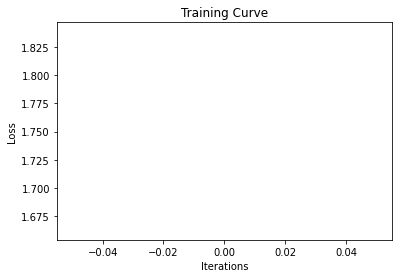

In [ ]:
model0 = LstmModel()

train_x,train_y,standard = pre_data()
myDs=MyDataset_2(train_x,train_y)
train_loader=torch.utils.data.DataLoader(myDs,batch_size=10,shuffle=False)
myDs=MyDataset(valid_data)
valid_loader=torch.utils.data.DataLoader(myDs,batch_size=10,shuffle=False)

train(model0, train_loader, valid_loader, n_epochs=1)

epoch 0, train loss 0.7125245928764343
epoch 1, train loss 0.7245961427688599
epoch 2, train loss 0.7366704344749451
epoch 3, train loss 0.7487422227859497
epoch 4, train loss 0.7608127593994141


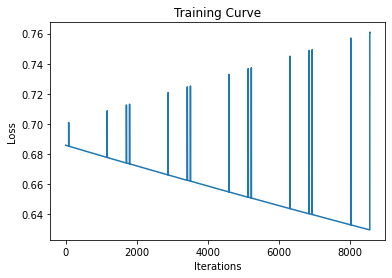

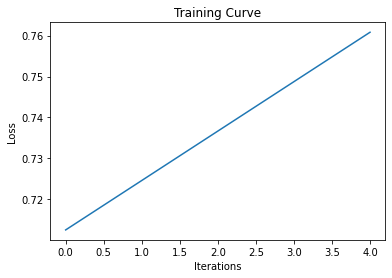

In [ ]:
model1 = LstmModel()

train_x,train_y,standard = pre_data()
myDs=MyDataset_2(train_x,train_y)
train_loader=torch.utils.data.DataLoader(myDs,batch_size=100,shuffle=False)
myDs=MyDataset(valid_data)
valid_loader=torch.utils.data.DataLoader(myDs,batch_size=100,shuffle=False)

train(model1, train_loader, valid_loader)

In [ ]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm ,model, test_x, test_y, title='Confusion matrix'):
  pred_y = model.predict(test_x)
  acc = accuracy_score(test_y,pred_y)
  f1 = f1_score(test_y, pred_y, average='binary')
  reg_cf = confusion_matrix(test_y, pred_y)
  fig, ax = plt.subplots(2, 2,figsize=(22,12))

  sns.heatmap(reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
  ax[0, 0].set_title(title, fontsize=14)
  ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
  ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)
  
  plt.show()


#  (3). Baseline MODEL

In [ ]:
from sklearn.linear_model import LogisticRegression

def baseline():
    train_x,train_y,standard = pre_data()

    test_x,test_y,_ = pre_data(test_path,standard,is_Train=True)

    base_model = LogisticRegression(random_state=0)

    base_model.fit(train_x,train_y)

    score_baseline(base_model, test_x, test_y)

In [ ]:
baseline()

prediction: [1 1 0 1 1 1 1 1 1 1]
real label: [1 1 1 1 1 1 1 1 1 1]
Accuracy: 0.999	F1 socre: 0.863	AUC:0.900
